<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    npr Mini-Challenge 1: <br>TFIDF-HGBC
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Jan Zwicky im HS 2023.
</p>

## Modellerklärung

Das Modell zur Klassifikation von Disaster Tweets besteht aus zwei Hauptkomponenten: einem Vectorizer und einem Classifier.

Der Vectorizer, in diesem Fall TFIDF (Term Frequency-Inverse Document Frequency), wandelt die Tweets in numerische Vektoren<br>
um. TFIDF berechnet für jedes Wort in einem Tweet einen Wert, der angibt, wie wichtig das Wort für den Tweet ist. Dabei wird<br>
die Häufigkeit des Wortes im Tweet (Term Frequency) mit der Seltenheit des Wortes im gesamten Textkorpus (Inverse Document<br>
Frequency) multipliziert. Dieser Prozess ermöglicht es, die Tweets in einem numerischen Raum darzustellen, in dem ähnliche<br>
Tweets nahe beieinander liegen.

Nachdem die Tweets mit dem Vectorizer in Vektoren umgewandelt wurden, werden sie dem Histogram Gradient Boosting Classifier<br>
zugeführt. Dieser Classifier ist eine Erweiterung des Gradient Boosting Classifiers und verwendet Histogramme, um die<br>
Effizienz des Trainings und der Vorhersage zu verbessern. Der Classifier lernt aus den TFIDF-Vektoren und<br>
erstellt ein Modell, das in der Lage ist, neue, nicht gekennzeichnete Tweets zu klassifizieren. Dabei wird der<br>
Disaster-Status (Ja/Nein) des Tweets vorhergesagt.

## Requirements, Imports und Einstellungen
Hier werden die benötigten Python-Pakete importiert und die Einstellungen für die Plots
vorgenommen. 

In [1]:
# All Imports
import sys
import html
import nltk
import scipy
import torch
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Versions of the packages used
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Scipy Version: {scipy.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {plt.matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")
print(f"Seaborn Version: {sns.__version__}")
print(f"NLTK Version: {nltk.__version__}")
print()

# Warnings Settings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Numpy Settings
np.set_printoptions(precision=2, suppress=True)
np.random.seed(42)

# Matplotlib Settings
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 100

# Pandas Settings
pd.options.display.max_colwidth = None

# NLTK Settings
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

Python Version: 3.11.6 (main, Oct  2 2023, 13:45:54) [Clang 15.0.0 (clang-1500.0.40.1)]
PyTorch Version: 2.1.0
Numpy Version: 1.25.2
Scipy Version: 1.11.3
Pandas Version: 2.1.1
Matplotlib Version: 3.7.0
Sklearn Version: 1.3.1
Seaborn Version: 0.12.2
NLTK Version: 3.8.1



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gabriel.torres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gabriel.torres/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Helper Functions

Hier werden Funktionen und Klassen definiert, die bei den Modellen verwendet werden.

In [2]:
# Metrics, shortcuts, constants, etc.
class Pipeline:
    """Pipeline for customizable text classification model."""

    def __init__(self, vectorizer, classifier, reducer=None) -> None:
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.reducer = reducer

    def __repr__(self) -> str:
        return f"Pipeline(vectorizer={self.vectorizer}, classifier={self.classifier}, reducer={self.reducer})"

    def fit(self, features, labels) -> "Pipeline":
        """
        Fit the model to the given training data.

        Parameters
        ----------
        features : list of str
            Training data features.
        labels : np.ndarray or pandas.Series
            Training data labels.

        Returns
        -------
        self
            The fitted model.
        """
        self.vectorizer.fit(features)
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            self.reducer.fit(transformed_features)
            transformed_features = self.reducer.transform(transformed_features)
        self.classifier.fit(transformed_features, labels)
        return self

    def predict(self, features) -> np.ndarray:
        """
        Predict labels for the given features.

        Parameters
        ----------
        features : list of str
            Features to predict labels for.

        Returns
        -------
        np.ndarray
            Predicted labels for the given features.
        """
        transformed_features = self.vectorizer.transform(features).toarray()
        if self.reducer:
            transformed_features = self.reducer.transform(transformed_features)
        return self.classifier.predict(transformed_features)

    def score(self, features, labels, metric="acc") -> np.float64:
        """
        Score the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to score the model on.
        labels : np.ndarray or pandas.Series
            Labels to score the model on.
        metric : str, optional
            Metric to use for scoring, by default "acc"

        Returns
        -------
        np.float64
            Score of the model on the given features and labels.
        """
        match metric:
            case "acc":
                return sklearn.metrics.accuracy_score(labels, self.predict(features))
            case "f1_macro":
                return sklearn.metrics.f1_score(labels, self.predict(features), average="macro")
            case _:
                raise ValueError(f"Unknown metric: {metric}")
            
    def validate(self, features, labels) -> None:
        """
        Validate the model on the given features and labels.

        Parameters
        ----------
        features : list of str
            Features to validate the model on.
        labels : np.ndarray or pandas.Series
            Labels to validate the model on.
        """
        predicted_labels = self.predict(features)

        print("Metrics")
        print(f"Accuracy: {self.score(features, labels, metric='acc')}")
        print(f"F1 Macro: {self.score(features, labels, metric='f1_macro')}")
        print()

        print("Confusion Matrix")
        conf_matrix = sklearn.metrics.confusion_matrix(labels, predicted_labels).astype(int)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', cbar=False,
                    xticklabels=['Predicted False', 'Predicted True'],
                    yticklabels=['Actual False', 'Actual True'],
                    annot_kws={"size": 16})
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        print()

        print("ROC Curve")
        probs = self.classifier.predict_proba(self.vectorizer.transform(features).toarray())
        fpr, tpr, _ = sklearn.metrics.roc_curve(labels, probs[:, 1])
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        print()

        print(f"Some first degree errors (predicted true, actual false)), Total: {np.sum((predicted_labels == 1) & (labels == 0))}")
        first_degree_errors = np.where((predicted_labels == 1) & (labels == 0))[0]
        first_degree_errors = pd.DataFrame({'Text': [html.unescape(features[i]) for i in first_degree_errors],})
        display(first_degree_errors.sample(10))
        print()

        print(f"Some second degree errors (predicted false, actual true)), Total: {np.sum((predicted_labels == 0) & (labels == 1))}")
        second_degree_errors = np.where((predicted_labels == 0) & (labels == 1))[0]
        second_degree_errors = pd.DataFrame({'Text': [html.unescape(features[i]) for i in second_degree_errors],})
        display(second_degree_errors.sample(10))

## Einlesen des verarbeiteten Datensatzes

In [3]:
train = pd.read_csv('data/processed/train.csv', index_col=0, encoding='UTF-8')
val = pd.read_csv('data/processed/val.csv', index_col=0, encoding='UTF-8')

X_train = train.text.values
X_val = val.text.values

y_train = train["target"].values
y_val = val["target"].values

Wir lesen die getrennten Datensätze ein und wandeln alle vorhandenen HTML Sonderzeichen in normale Zeichen um.<br>
In unseren X Arrays befinden sich die Sätze untokenisiert. Der TFIDF Vectorizer "tokenisiert" die Sätze automatisch.


## Trainieren des Klassifikationsmodell

In [4]:
# define preprocessing
def preprocess(
    tweet, html_escape=True, tokenizer=nltk.tokenize.word_tokenize, lemmatize=True, stem=True
):
    tweet = html.unescape(tweet) if html_escape else tweet

    tweet = tokenizer(tweet) if stem or lemmatize else tweet
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tweet = [lemmatizer.lemmatize(word) for word in tweet] if lemmatize else tweet
    tweet = [nltk.stem.PorterStemmer().stem(word) for word in tweet] if stem else tweet
    tweet = " ".join(tweet) if stem or lemmatize else tweet

    return tweet


# Define Pipeline
TFIDF_HGBC = Pipeline(
    vectorizer=TfidfVectorizer(
        max_features=1000,
        preprocessor=lambda tweet: preprocess(
            tweet,
            html_escape=True,
            tokenizer=nltk.word_tokenize,
            lemmatize=True,
            stem=True,
        ),
        tokenizer=nltk.word_tokenize,
        token_pattern=None,
    ),
    classifier=HistGradientBoostingClassifier(),
    reducer=None,  # None, PCA, NMF, etc.
)

# Fit Pipeline
TFIDF_HGBC.fit(X_train, y_train)

Pipeline(vectorizer=TfidfVectorizer(max_features=1000,
                preprocessor=<function <lambda> at 0x28846d9e0>,
                token_pattern=None,
                tokenizer=<function word_tokenize at 0x12f7447c0>), classifier=HistGradientBoostingClassifier(), reducer=None)

Für das Trainieren des Modells wird der TFIDF Vectorizer verwendet, um die Sätze in Matrizen umzuwandeln. <br>
Die Matrizen werden dann in den HGBC gegeben, um das Modell zu trainieren. <br>

Zwischen TFIDF Vectorizer und HGBC besteht die Option, eine Dimensionsreduktion durchzuführen. <br>
Jedoch ist dies in vielen Fällen langsamer und führt zu schlechteren Ergebnissen. <br>
Alternativ kann man dem Vectorizer mitteilen, nur die 1000 wichtigsten Wörter zu verwenden.<br> 
Dies führt erstaunlicherweise nicht zu schlechteren Ergebnissen. Möglicherweise wegen der Simplizität unseres Datensatzes.<br>

## Auswertung des Klassifikationsmodell

TODO: Welche Metriken und wieso passen diese (zum Anwenungsfall)?

Als erstes Überprüfen wir unser Modell auf den Trainingsdaten.

Metrics
Accuracy: 0.8879425517702071
F1 Macro: 0.8827769616112922

Confusion Matrix


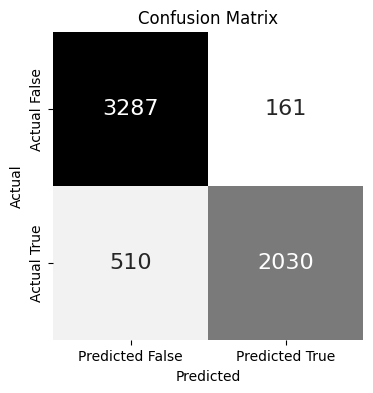


ROC Curve


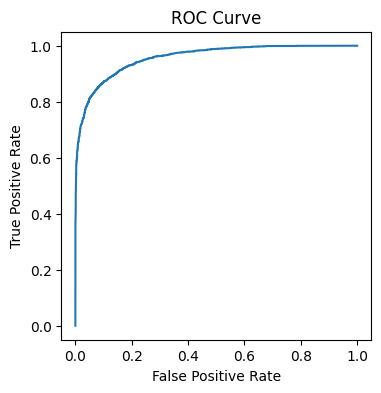


Some first degree errors (predicted true, actual false)), Total: 161


,Text
158,We should all have a fire safety plan. RT @Matt_Kroschel: MOCK WILDFIRE near #Vail as agencies prepare for the worst. http://t.co/SWwyLRk0fv
109,@BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.
131,Nike Golf Storm Fit Golf Jacket Black Medium http://t.co/jvAI5Vkmsy: #SportingGoods http://t.co/Nr8JjmpmoS
55,For those displaced by disasters label and legal status remain out of reach https://t.co/kJMgTEEklp
94,Bayelsa poll: Tension in Bayelsa as Patience Jonathan plans to hijack APC PDP: Plans by former First Lady and... http://t.co/3eJL9lZlCH
29,Warne Ponting shocked by Australian collapse - Yahoo Cricket India https://t.co/hsgkTeZUCN
101,Stream HYPE HURRICANE
51,@Bonn1eGreer The Angel of History propelled into the future by the winds of progress leaves in its wake piles of death and destruction. WB
100,Entertain this thought for a moment:\n\ndiarrhea hurricane
144,OMEGA MEN Writer Explores Terrorism Religion In an 'Epic KYLE RAYNER Story' http://t.co/Hr88CWxPGz #Newsarama



Some second degree errors (predicted false, actual true)), Total: 510


,Text
86,@marcoarment Middle of winter in Sydney we have had snow bush fires and 78 degree days in the last week. Keeps you on your toes for sure.
350,@tinybaby @adultblackmale @mattytalks meltdown mwednesday
199,Could Billboard's Hot 100 chart be displaced by these social-media-driven music charts? http://t.co/WVlaH8jRXe
210,Wall of noise is one thing - but a wall of dust? Moving at 60MPH? http://t.co/9NwAJLi9cr How to not get blown away! http://t.co/j4NI4N0yFZ
87,@DoriCreates @alhanda seems gov moonbeam between tokes blames bush for all the fires.
138,SO THIRSTY YALL IN DANGER OF DEHYDRATION
31,Trial Date Set for Man Charged with Arson Burglary http://t.co/WftCrLz32P
40,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/xFguklrlTf http://t.co/FeGu8hWMc4
192,@argentings WE COULD HAVE HAD IT AAAAAAALLLL IÛªm not even on that season and IÛªm devastated
476,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.


In [5]:
TFIDF_HGBC.validate(X_train, y_train)

Beim Auswerten des Modells auf den Trainingsdaten erreichen wir recht hohe Metriken. Das Modell macht aber sehr viele Fehler zweiten Grades.<br>
Wenn man aber die falsch klassifizierten Sätze sieht, sehen wir ein komisches Muster:<br>
Einige Sätze, welche als Katastrophe klassifiziert werden, sehen nicht gerade nach Katastrophen aus oder können nur nach Einsicht eines Links so <br>klassifiziert werden. <br><br>
Zum Beispiel:<br> 
"@freeMurphy Your hot take on Canada's hitchhiking garbage-bot (destroyed in Philly) was sorely needed."<br>
"ok peace I hope I fall off a cliff along with my dignity"<br>
"This is the natural and unavoidable consequence of socialism everywhere it has been tried.http://t.co/BbDpnj8XSx A"<br><br>
Bei den Fehlern ersten Grades kann man schon besser nachvollziehen, wieso das Modell diese falsch klassifiziert hat. <br>
Wörter wie "hostage", "suicide bomb" oder "wars" werden genutzt, um einen Satz dramatischer wirken zu lassen. <br>
Das Modell hat Schwierigkeiten, diese Zusammenhänge im Kontext korrekt zu erkennen.

Metrics
Accuracy: 0.7889111556446226
F1 Macro: 0.7773587960435405

Confusion Matrix


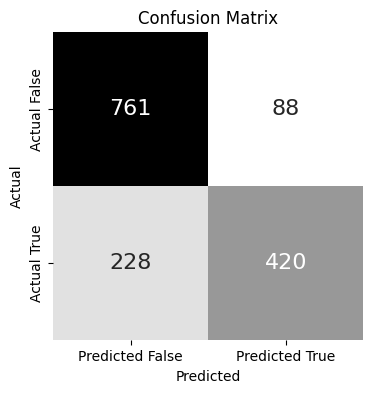


ROC Curve


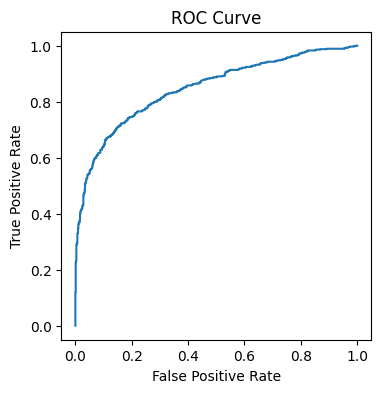


Some first degree errors (predicted true, actual false)), Total: 88


,Text
3,@marksmaponyane Hey!Sundowns were annihilated in their previous meeting with Celtic.Indeed its an improvement.
66,Captain Abbott must go down with LNP boat #refugees #christianvalues https://t.co/Kp5dpOaF58
86,GOP debate drinking game. For anyone looking for a bit of fun while watching this train wreck. http://t.co/W3Rga0nkOm http://t.co/0TZsQe8ESD
84,Camping in a war zone with roving raccoons toughens city slicker http://t.co/oJuS08yZrq
69,China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this summer h... http://t.co/pE2R3lN16o by .Forbes
79,I feel like that episode of Victorious when they all got trapped in an RV and almost died of heat stroke #MTVHottest One Direction
36,The Five Fatal Flaws in the Iran Deal https://t.co/ztfEAd8GId via @YouTube
76,FERNO would appreciate if everyone in EMS could dust off their engineering degree & inspect all stretcher components. http://t.co/GTEd6LDwho
64,- Pandemonium In Aba As Woman Delivers Baby Without Face http://t.co/36GccAPaak http://t.co/nqjZS6wkuN
43,@kristenKOIN6 Yay good cooler weather for PDX..ABQ NM is feeling the heat wave now bcuz my rain dances aren't working :-)



Some second degree errors (predicted false, actual true)), Total: 228


,Text
75,So you have a new weapon that can cause un-imaginable destruction.
99,Tube strike live: Latest travel updates as London is engulfed in chaos: Û_ cross-London travel will be accepte... http://t.co/vg8HRbebdA
96,Hello Calgary!! Important news!! Please be advised!!! http://t.co/ARKTJ9Qn4S
175,The real question is why is the tornado siren going off in Dyersburg?
34,Learning from the Legacy of a Catastrophic Eruption - The New Yorker http://t.co/vMWTOUyOHm
64,News Alerts - Glimpses: Hyderabad deluged by heavy rainfall
135,@pattonoswalt @FoxNews Wait I thought Fecal Hurricane was on SciFi? Maybe that was turdnado. I've been forgeting up a shit storm lately.
158,Oops: Bounty hunters try to raid Phoenix police chief's home: A group of armed bounty hunters surrounded the h... http://t.co/dGELJ8rYt9
48,AKILAH WORLD NEWS Cop pulls man from car to avoid this ... http://t.co/Vn2Fnmy7li
116,As firefighters make gains on #RockyFire Jerry Brown is heading to the area to meet with first responders tomorrow morning


In [6]:
TFIDF_HGBC.validate(X_val, y_val)

Beim Auswerten des Modells auf den Validierungsdaten sehen wir, dass die Scores deutlich zum Trainingsdatensatz gesunken sind, <br>jedoch noch gute Ergebnisse zeigen.<br>

Hier ist das Ausmass der Fehler zweiten Grades verglichen zu den Fehlern ersten Grades etwas kleiner als bei der Validierung mit den Trainingsdaten.<br>
Viele Fehler zweiten Grades sind hier sehr warhscheinlich Antworten zu Threads, welche Katastrophenrelevant sind. <br>
Dies macht diese Klassifikation unglaublich schwierig, da der Kontext dafür einfach fehlt.

Zum Beispiel:<br> 
"@AsimTanvir @NemesisK_PES @KevR_7 Snow? Thunder and lightning?"<br>
"I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-"<br>
"@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work."<br>

Bei den Fehlern ersten Grades ziehe ich die gleichen Erkenntnisse wie bei der vorherigen Validierung.<br>
Es sieht so aus als würden einige Triggerwords wi z.B. "**Crash**" (von Crash Course) das Modell stark beinflussen.

TODO: Metriken kommentieren.

## Erkenntnisse

TODO: Alle Erkenntnisse zusammentragnen.

## Fazit

TODO: Bei den anderen abschauen.

## Kaggle Submission

Hier lassen wir noch die Testdaten durch das Modell laufen und speichern die Ergebnisse in einer CSV Datei.<br>
Diese kann bei der Kaggle Competition hochgeladen werden.

In [7]:
kaggle_test = pd.read_csv('data/processed/test.csv', index_col="id", encoding="UTF-8")
X_test = [html.unescape(tweet) for tweet in kaggle_test["text"]]

submisson = TFIDF_HGBC.predict(X_test)
submisson = pd.DataFrame(submisson, index=kaggle_test.index, columns=["target"])
submisson.to_csv("data/submissions/TFIDF_HGBC.csv", index=True, index_label="id")